# Medical Insurance Premium Prediction

## What problem this solves
Insurance providers need to estimate how much a customer’s medical insurance will cost before issuing a policy. Premiums depend on demographic and lifestyle factors such as age, BMI, smoking status, and region. Accurate prediction helps insurers:

* Price policies competitively
* Reduce financial risk
* Identify high-risk profiles early

This notebook builds and evaluates multiple regression models to predict medical insurance charges using customer attributes, and compares traditional statistical models against a neural network.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from pathlib import Path
# from jupyterthemes import jtplot
# jtplot.style(theme = 'monokai', context = 'notebook', ticks = True, grid = False) 


dataset_path = Path.cwd() / "datasets"

df = pd.read_csv(dataset_path / "insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


load a tabular dataset containing:

* Numerical features: age, BMI, number of children
* Categorical features: sex, smoker status, geographic region
* Target variable: insurance charges

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


### Exploratory Data Analysis

Missing data can silently distort predictions. This step verifies data quality before modeling.

<Axes: >

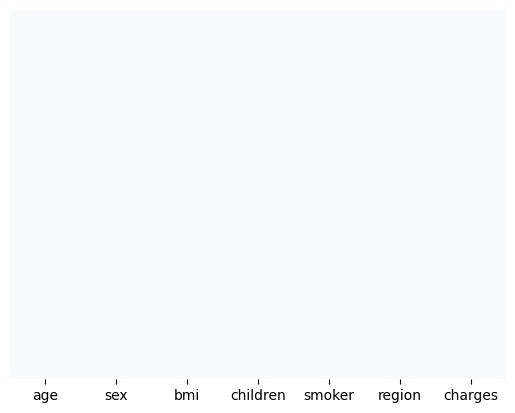

In [4]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap="Blues")

#### Note: We do not have any missing element

In [5]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [6]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [8]:
df_region = df.groupby(by='region').mean(numeric_only=True)
df_region

,age,bmi,children,charges
region,,,,
northeast,39.268519,29.173503,1.046296,13406.384516
northwest,39.196923,29.199785,1.147692,12417.575374
southeast,38.939560,33.355989,1.049451,14735.411438
southwest,39.455385,30.596615,1.141538,12346.937377


#### Group data by age

In [11]:
df_age = df.groupby(by='age').mean(numeric_only=True)
df_age

,bmi,children,charges
age,,,
18,31.326159,0.449275,7086.217556
19,28.596912,0.426471,9747.909335
20,30.632759,0.862069,10159.697736
21,28.185714,0.785714,4730.464330
22,31.087679,0.714286,10012.932802
23,31.454464,1.000000,12419.820040
24,29.142679,0.464286,10648.015962
25,29.693929,1.285714,9838.365311
26,29.428929,1.071429,6133.825309


In [12]:
df['sex'].unique()

array(['female', 'male'], dtype=object)

##### Convert Categorical variable to numerical

In [13]:
df['sex'] = df['sex'].apply(lambda x: 0 if x=='female' else 1)

In [14]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,yes,southwest,16884.92400
1,18,1,33.770,1,no,southeast,1725.55230
2,28,1,33.000,3,no,southeast,4449.46200
3,33,1,22.705,0,no,northwest,21984.47061
4,32,1,28.880,0,no,northwest,3866.85520


In [15]:
df['smoker'].unique()

array(['yes', 'no'], dtype=object)

In [16]:
df['smoker']= df['smoker'].apply(lambda x: 0 if x == 'no' else 1)

In [17]:
region_dummies = pd.get_dummies(df['region'], drop_first = True, dtype=int)

In [18]:
region_dummies

,northwest,southeast,southwest
0,0,0,1
1,0,1,0
2,0,1,0
3,1,0,0
4,1,0,0
...,...,...,...
1333,1,0,0
1334,0,0,0
1335,0,1,0
1336,0,0,1


In [19]:
insurance_df = pd.concat([df, region_dummies], axis=1)

In [20]:
insurance_df.head()

,age,sex,bmi,children,smoker,region,charges,northwest,southeast,southwest
0,19,0,27.900,0,1,southwest,16884.92400,0,0,1
1,18,1,33.770,1,0,southeast,1725.55230,0,1,0
2,28,1,33.000,3,0,southeast,4449.46200,0,1,0
3,33,1,22.705,0,0,northwest,21984.47061,1,0,0
4,32,1,28.880,0,0,northwest,3866.85520,1,0,0


In [21]:
insurance_df.drop(['region'], axis = 1, inplace = True)

In [22]:
insurance_df.head()

,age,sex,bmi,children,smoker,charges,northwest,southeast,southwest
0,19,0,27.900,0,1,16884.92400,0,0,1
1,18,1,33.770,1,0,1725.55230,0,1,0
2,28,1,33.000,3,0,4449.46200,0,1,0
3,33,1,22.705,0,0,21984.47061,1,0,0
4,32,1,28.880,0,0,3866.85520,1,0,0


#### Perform Data Visualization

array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'sex'}>],
       [<Axes: title={'center': 'bmi'}>,
        <Axes: title={'center': 'children'}>],
       [<Axes: title={'center': 'smoker'}>,
        <Axes: title={'center': 'charges'}>]], dtype=object)

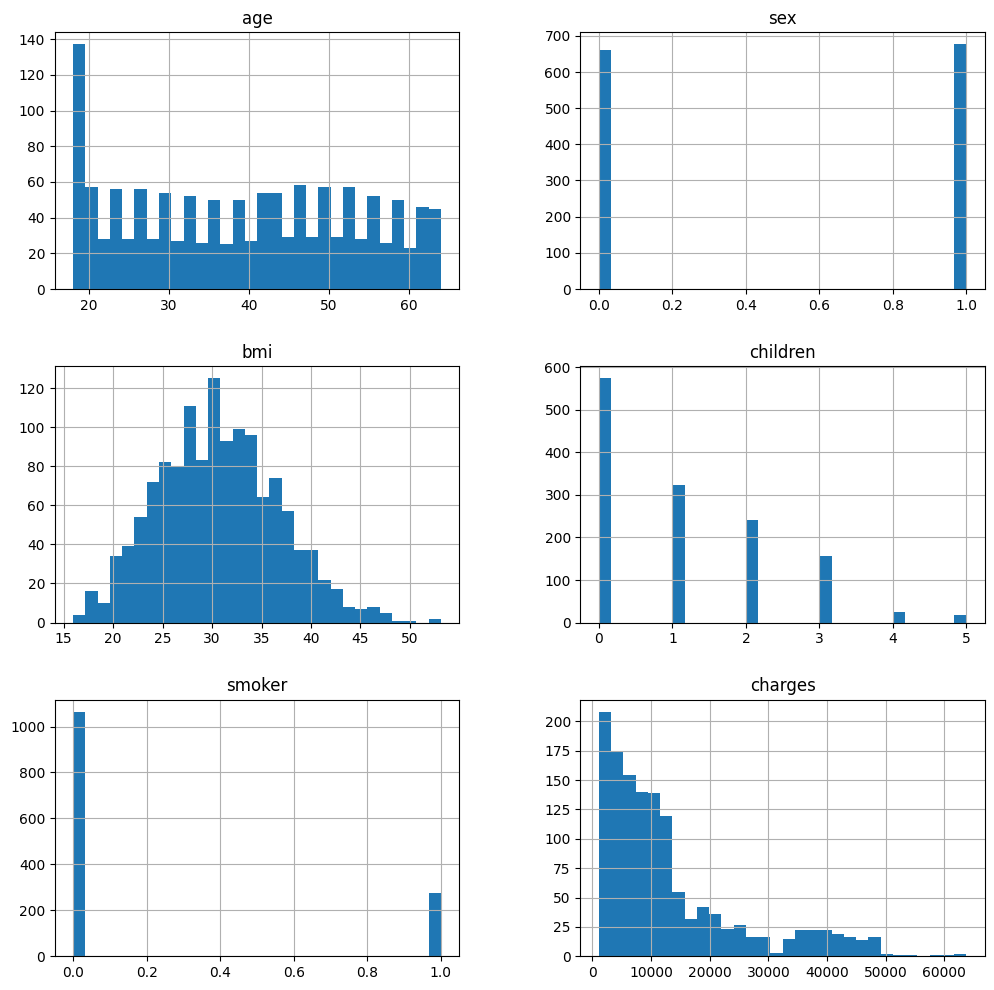

In [23]:
insurance_df[['age', 'sex', 'bmi','children','smoker','charges']].hist(bins=30, figsize=(12,12))

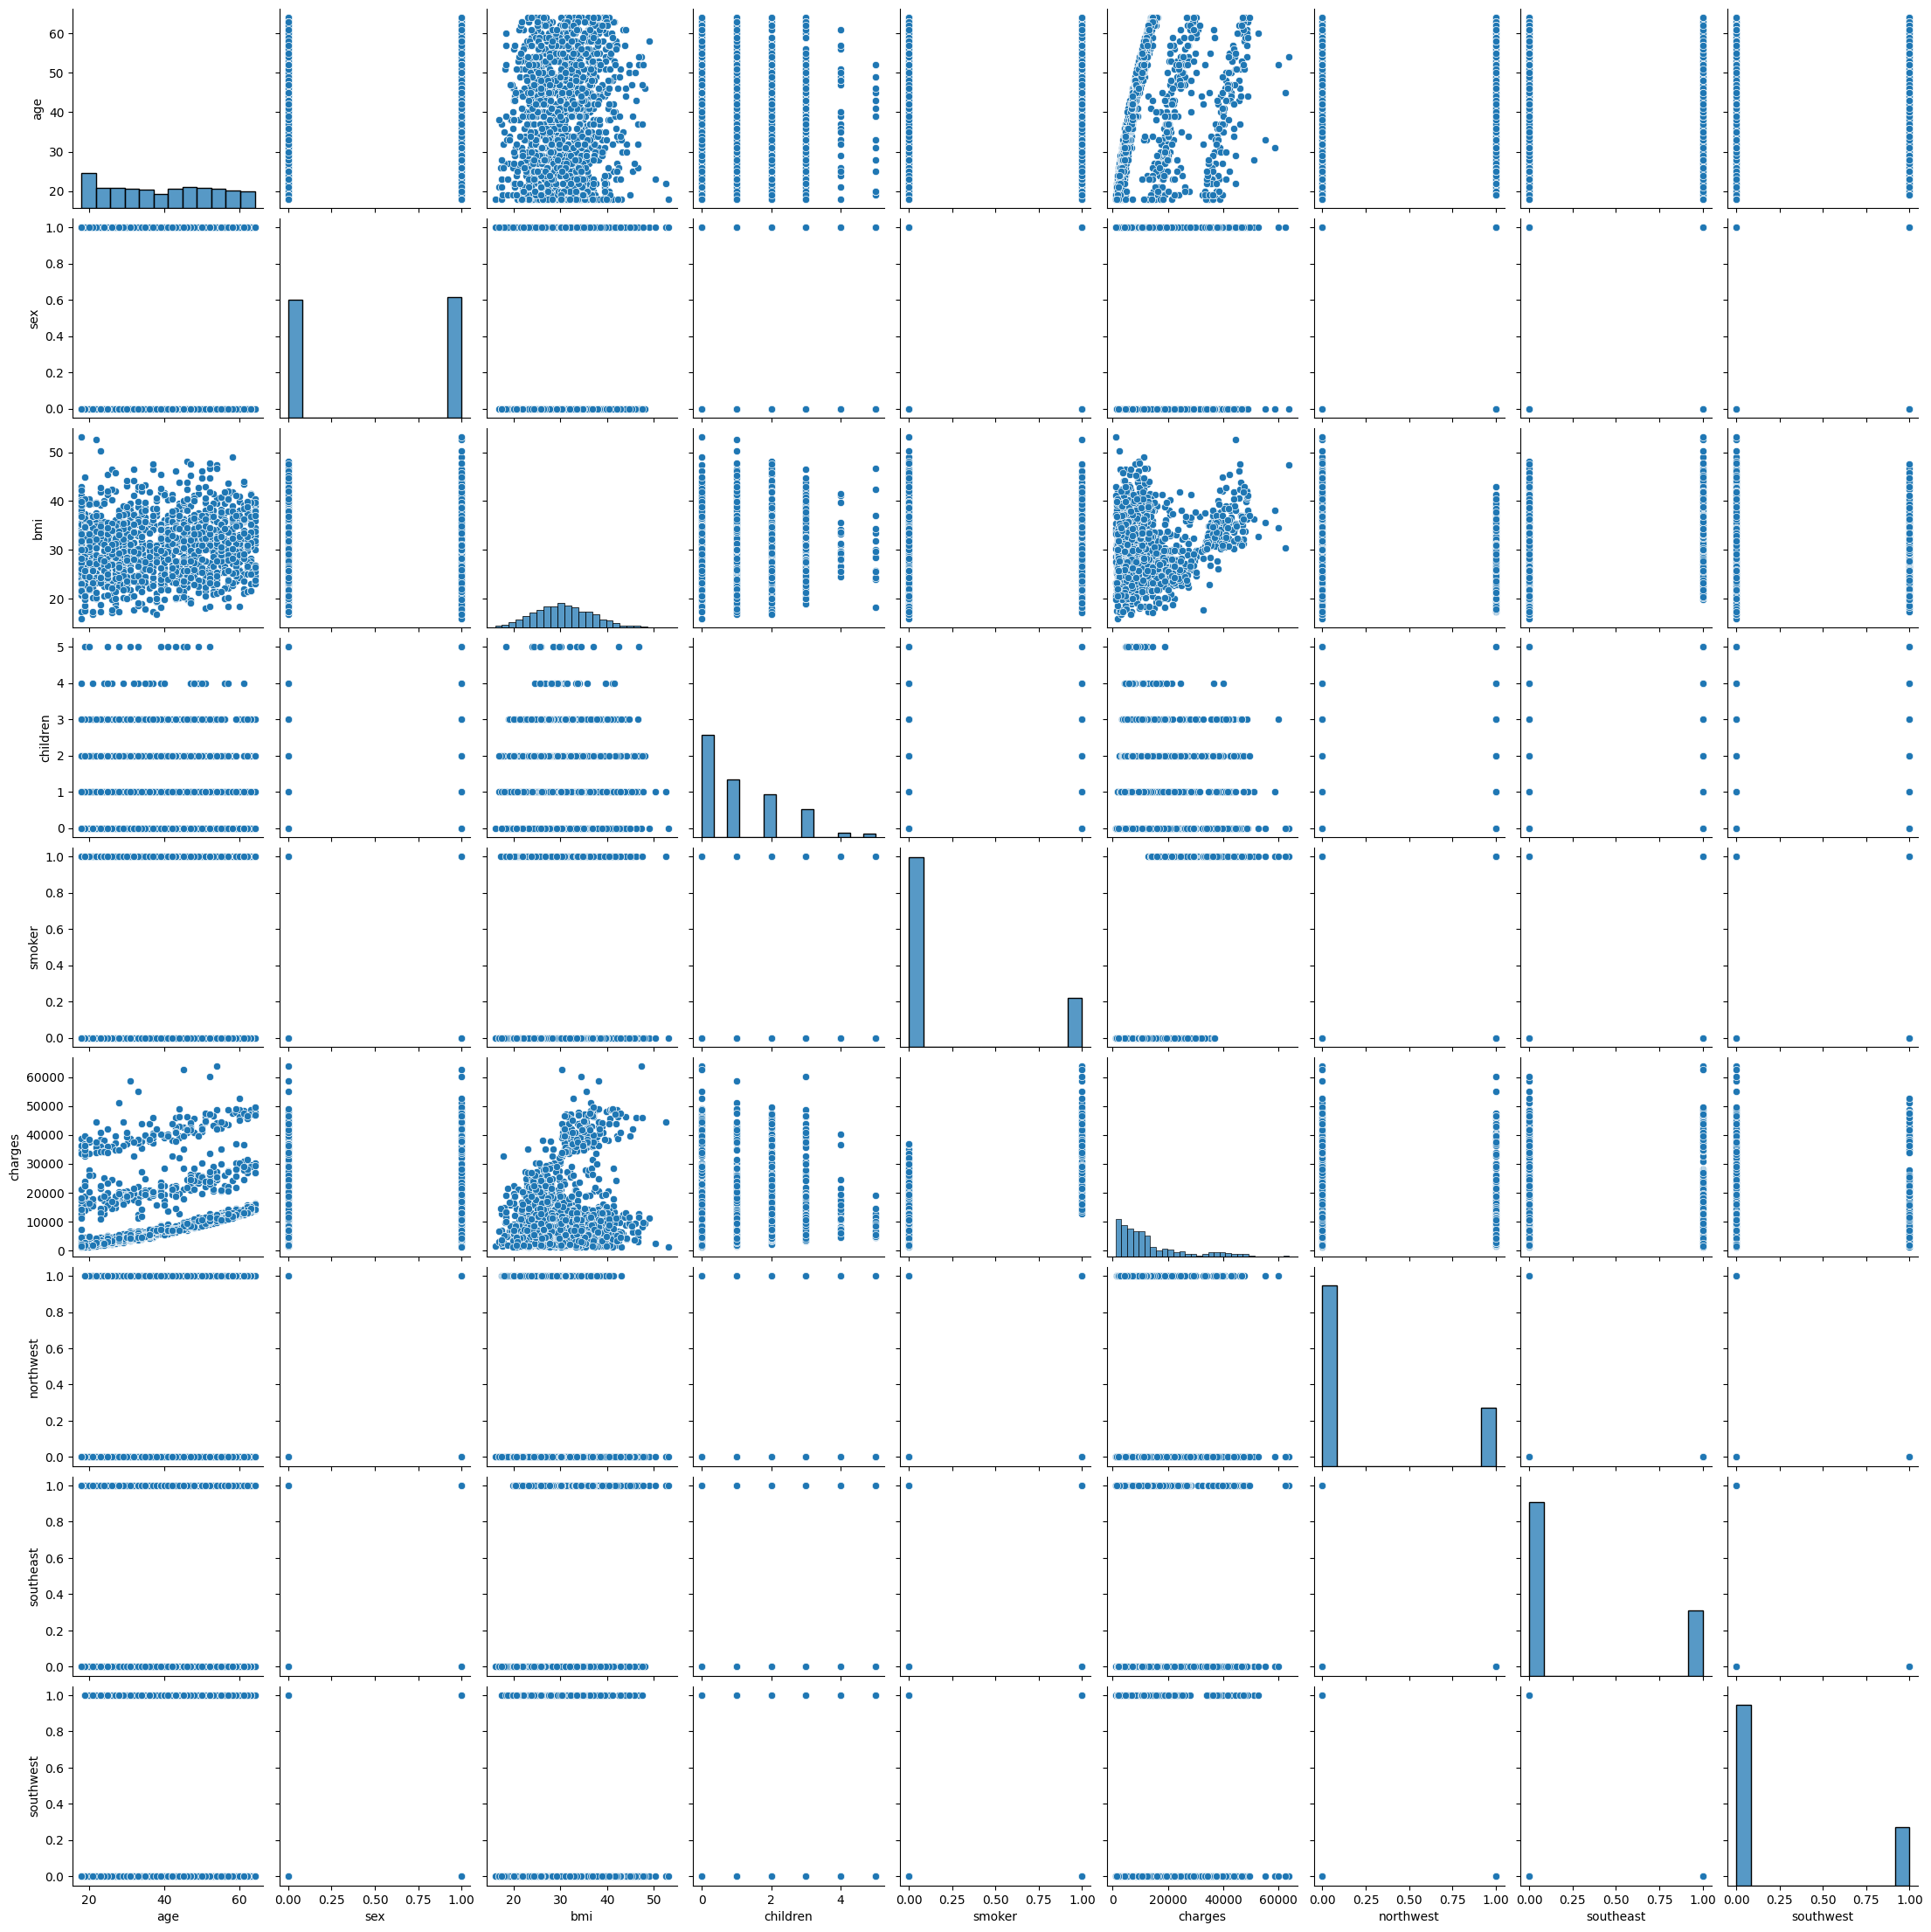

In [24]:
sns.pairplot(insurance_df)

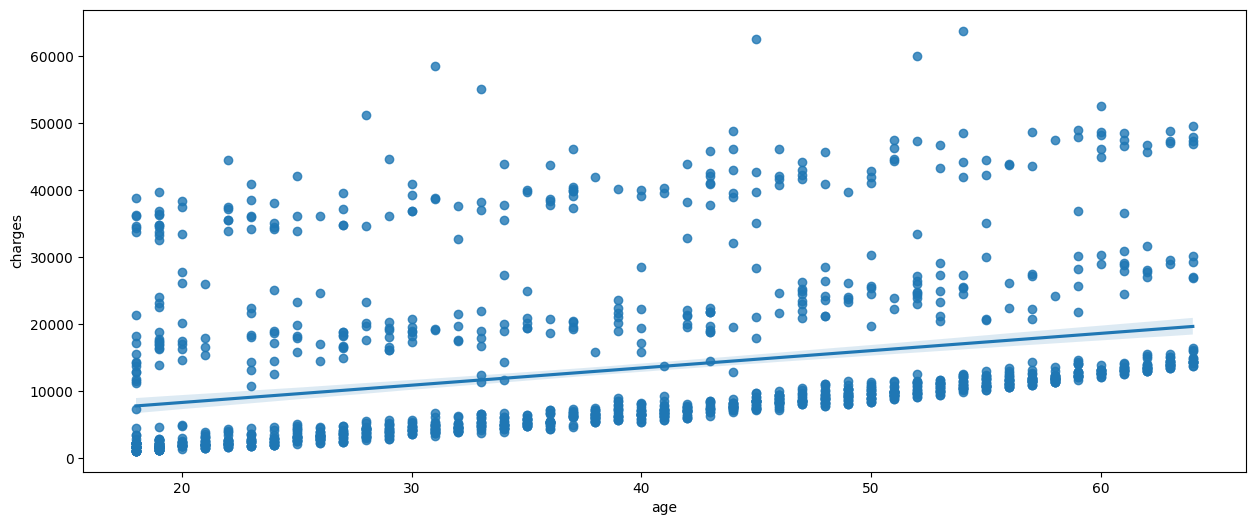

In [25]:
plt.figure(figsize=(15,6))
sns.regplot(x = 'age', y = 'charges', data = insurance_df)
plt.show()

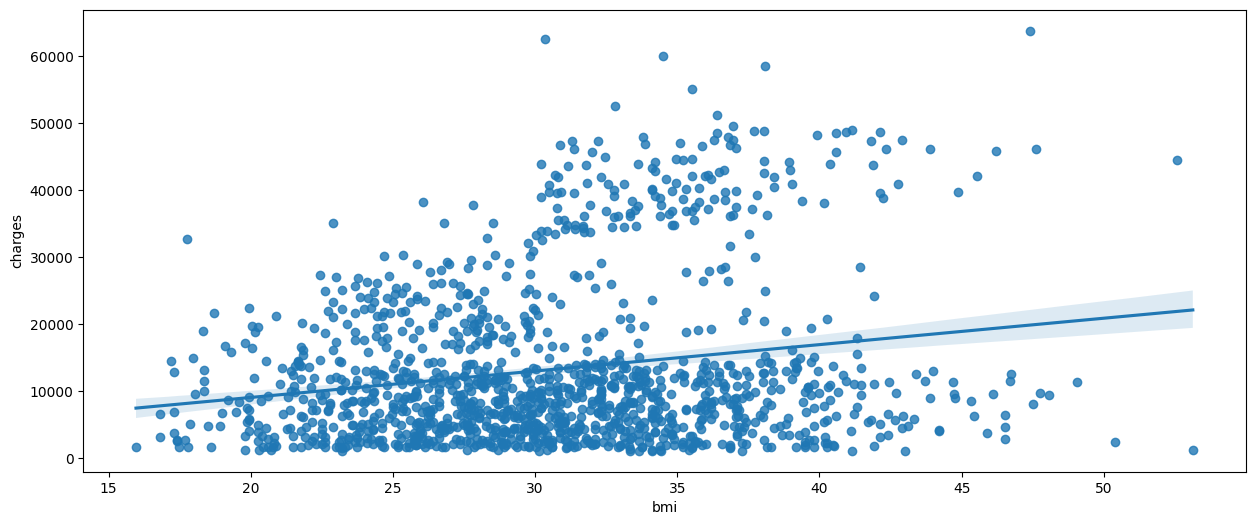

In [26]:
plt.figure(figsize = (15, 6))
sns.regplot(x = 'bmi', y = 'charges', data = insurance_df)
plt.show()

#### Calculate and plot the correlation matrix

In [27]:
insurance_df.corr()

,age,sex,bmi,children,smoker,charges,northwest,southeast,southwest
age,1.000000,-0.020856,0.109272,0.042469,-0.025019,0.299008,-0.000407,-0.011642,0.010016
sex,-0.020856,1.000000,0.046371,0.017163,0.076185,0.057292,-0.011156,0.017117,-0.004184
bmi,0.109272,0.046371,1.000000,0.012759,0.003750,0.198341,-0.135996,0.270025,-0.006205
children,0.042469,0.017163,0.012759,1.000000,0.007673,0.067998,0.024806,-0.023066,0.021914
smoker,-0.025019,0.076185,0.003750,0.007673,1.000000,0.787251,-0.036945,0.068498,-0.036945
charges,0.299008,0.057292,0.198341,0.067998,0.787251,1.000000,-0.039905,0.073982,-0.043210
northwest,-0.000407,-0.011156,-0.135996,0.024806,-0.036945,-0.039905,1.000000,-0.346265,-0.320829
southeast,-0.011642,0.017117,0.270025,-0.023066,0.068498,0.073982,-0.346265,1.000000,-0.346265
southwest,0.010016,-0.004184,-0.006205,0.021914,-0.036945,-0.043210,-0.320829,-0.346265,1.000000


<Axes: >

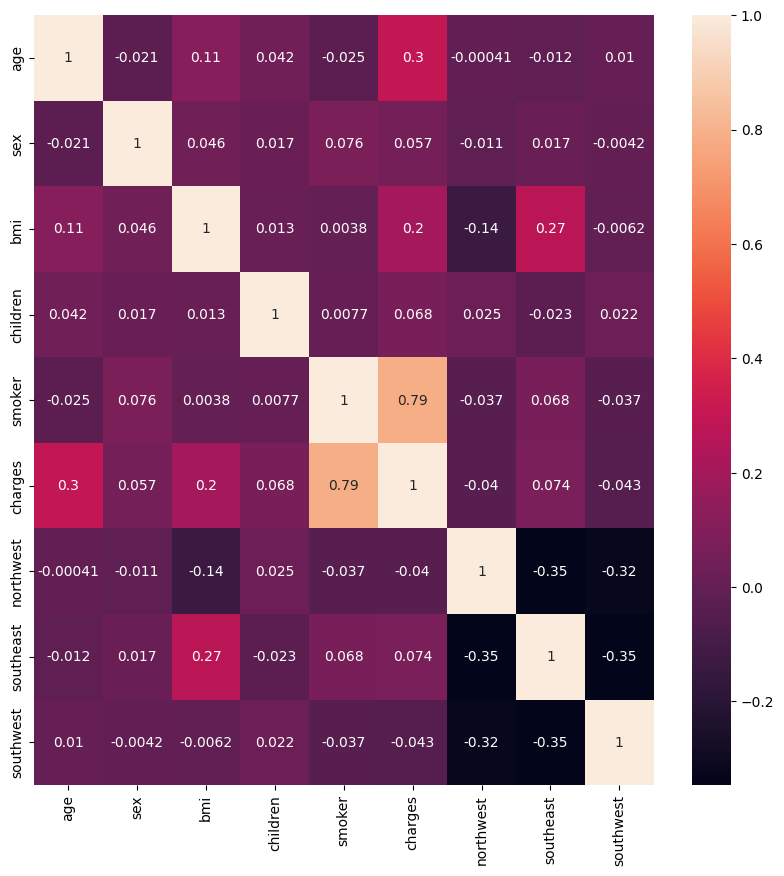

In [28]:
plt.figure(figsize=(10,10))
sns.heatmap(insurance_df.corr(), annot=True)

#### Prepare Training and Testing Dataset

In [29]:
insurance_df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'charges', 'northwest',
       'southeast', 'southwest'],
      dtype='object')

**X (features):** age, sex, BMI, children, smoker, region indicators

**y (target):** charges

In [30]:
X = insurance_df.drop(columns=['charges'])
y = insurance_df['charges']

In [31]:
X = np.array(X).astype('float32')
y = np.array(y).astype('float32')
y = y.reshape(-1,1)

In [32]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler_x = StandardScaler()
X = scaler_x.fit_transform(X)

scaler_y = StandardScaler()
y = scaler_y.fit_transform(y)


#### Split the data into 20% Testing and 80% Training

**Training set:** used to learn patterns

**Test set:** used to evaluate real-world performance

We train the model on historical data and then test it on “unseen” customers to check whether it generalizes, not just memorizes.

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=10)

#### Train and Evaluate a Linear Regression

Linear regression assumes a straight-line relationship between each input factor and insurance cost.

This model captures broad trends (e.g., smokers cost more) but struggles with complex interactions.

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score

regresssion_model_sklearn = LinearRegression()
regresssion_model_sklearn.fit(X_train, y_train)


LinearRegression()

In [35]:
regresssion_model_sklearn_accuracy = regresssion_model_sklearn.score(X_test, y_test)
regresssion_model_sklearn_accuracy

0.6953286617446484

In [36]:
y_predict = regresssion_model_sklearn.predict(X_test)

In [37]:
y_predict_orig = scaler_y.inverse_transform(y_predict)
y_test_orig = scaler_y.inverse_transform(y_test)

In [38]:
k = X_test.shape[1]
n = len(X_test)
n

268

In [39]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from math import sqrt


RMSE = float(format(np.sqrt(mean_squared_error(y_test_orig, y_predict_orig)),'.3f'))
MSE = mean_squared_error(y_test_orig, y_predict_orig)
MAE = mean_absolute_error(y_test_orig, y_predict_orig)
r2 = r2_score(y_test_orig, y_predict_orig)
adj_r2 = 1-(1-r2)*(n-1)/(n-k-1)

print('RMSE =',RMSE, '\nMSE =',MSE, '\nMAE =',MAE, '\nR2 =', r2, '\nAdjusted R2 =', adj_r2) 

RMSE = 6536.847 
MSE = 42730370.0 
MAE = 4555.099 
R2 = 0.6953286762768424 
Adjusted R2 = 0.6859179790189842


The linear model explains a majority of cost variation but leaves room for improvement, indicating non-linear effects in healthcare pricing.

#### Train and evaluate an Artificial Neural Network-based regression model

##### Next step is to train in ANN

Unlike linear regression, the neural network can learn complex interactions—such as how age and smoking together amplify risk.

The ANN improves flexibility but sacrifices interpretability. In regulated industries like insurance, this trade-off must be carefully justified.

In [40]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [41]:
ANN_model = keras.Sequential()
ANN_model.add(Dense(50, input_dim = 8))
ANN_model.add(Activation('relu'))
ANN_model.add(Dense(150))
ANN_model.add(Activation('relu'))
ANN_model.add(Dense(150))
ANN_model.add(Activation('relu'))
ANN_model.add(Dense(50))
ANN_model.add(Activation('linear'))
ANN_model.add(Dense(1))
ANN_model.compile(loss = 'mse', optimizer = 'adam')
ANN_model.summary()

e:\Python\2024_machine_learning_projects\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 50)             │           450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 150)            │         7,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 150)            │        22,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 50)             │         7,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,351 (149.81 KB)

 Trainable params: 38,351 (149.81 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
ANN_model.compile(optimizer='Adam', loss='mean_squared_error')
epochs_hist = ANN_model.fit(X_train, y_train, epochs=100, batch_size=20, validation_split=0.2)

Epoch 1/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.6128 - val_loss: 0.2068
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1677 - val_loss: 0.1799
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1340 - val_loss: 0.1967
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1802 - val_loss: 0.1789
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1313 - val_loss: 0.1647
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1227 - val_loss: 0.1721
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1172 - val_loss: 0.1725
Epoch 8/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1062 - val_loss: 0.1795
Epoch 9/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1122 - val_loss: 0.1788
Epoch 10/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1116 - val_loss: 0.1948
Epoch 11/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1075 - val_loss: 0.1945
Epoch 12/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0

In [43]:
result = ANN_model.evaluate(X_test, y_test)
accuracy_ANN = 1 - result
print("Accuracy : {}".format(accuracy_ANN))

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2788  
Accuracy : 0.6982606947422028


In [44]:
epochs_hist.history.keys()

dict_keys(['loss', 'val_loss'])

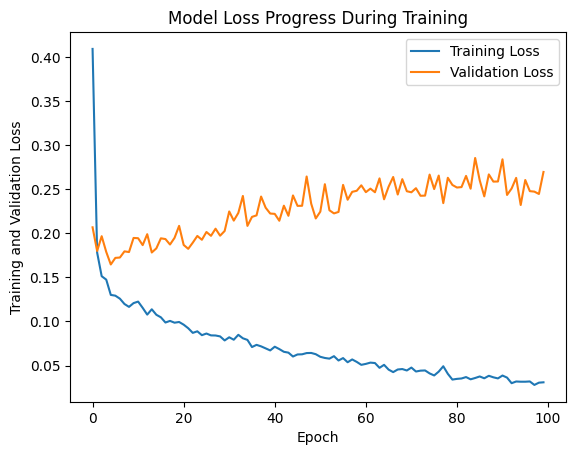

In [45]:
plt.plot(epochs_hist.history['loss'])
plt.plot(epochs_hist.history['val_loss'])
plt.title('Model Loss Progress During Training')
plt.xlabel('Epoch')
plt.ylabel('Training and Validation Loss')
plt.legend(['Training Loss', 'Validation Loss'])

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Text(0, 0.5, 'True Values')

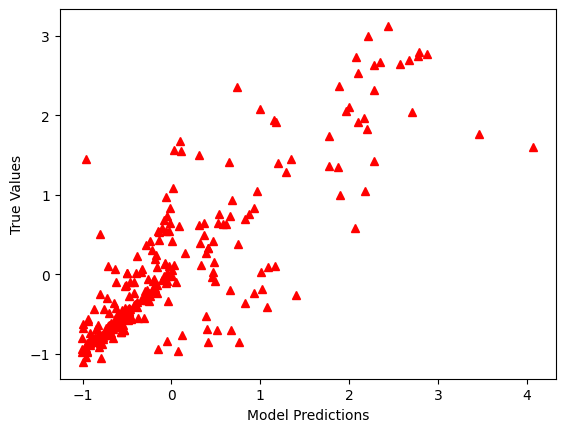

In [46]:
y_predict = ANN_model.predict(X_test)
plt.plot(y_test, y_predict, "^", color = 'r')
plt.xlabel('Model Predictions')
plt.ylabel('True Values')

In [47]:
y_predict_orig = scaler_y.inverse_transform(y_predict)
y_test_orig = scaler_y.inverse_transform(y_test)

Text(0, 0.5, 'True Values')

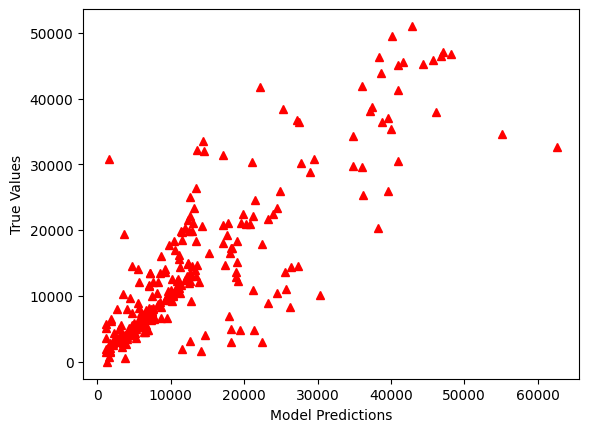

In [48]:
plt.plot(y_test_orig, y_predict_orig, "^", color = 'r')
plt.xlabel('Model Predictions')
plt.ylabel('True Values')

In [49]:
k = X_test.shape[1]
n = len(X_test)
n

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from math import sqrt

RMSE = float(format(np.sqrt(mean_squared_error(y_test_orig, y_predict_orig)),'.3f'))
MSE = mean_squared_error(y_test_orig, y_predict_orig)
MAE = mean_absolute_error(y_test_orig, y_predict_orig)
r2 = r2_score(y_test_orig, y_predict_orig)
adj_r2 = 1-(1-r2)*(n-1)/(n-k-1)

print('RMSE =',RMSE, '\nMSE =',MSE, '\nMAE =',MAE, '\nR2 =', r2, '\nAdjusted R2 =', adj_r2) 

RMSE = 6649.64 
MSE = 44217710.0 
MAE = 3988.7397 
R2 = 0.6847237509860764 
Adjusted R2 = 0.6749854884682718
